# Summative 2 Assignment

## Summary Statement
The following notebook charts the implementation behind a work project, looking at using company financial variables to try to predict subsequent company liquidations. It maps this process to the data science lifecycle, and outlines proposed methods for data discovery and analysis. Different modelling choices are discussed, and a proposal made based on this rhetoric. Plans on how to train, evaluate and deploy this model are discussed, as well the specific reasoning behind the proposed choices for this business case.


In [1]:
# First import libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.naive_bayes import GaussianNB #Gaussian Naive Bayes classifier
from sklearn.neighbors import KNeighborsClassifier #Classifier implementing the k-nearest neighbors vote
from sklearn.tree import DecisionTreeClassifier, export_graphviz # Decision Tree Classifier using CART 4.5
from sklearn import tree # for plotting trees
from sklearn.linear_model import LogisticRegression #Logistic Regression Classifier
from sklearn.model_selection import GridSearchCV # gridsearch wrapper for hyperparameters
from sklearn.preprocessing import LabelEncoder # encoder for mapping categorical string variables to numeric
import seaborn as sns #for nice visualisations
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay #metrics
from sklearn.preprocessing import StandardScaler #for scaling
from sklearn.model_selection import train_test_split #for sperating train and test samples

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

ImportError: cannot import name 'ConfusionMatrixDisplay'

## Business use case:
The ‘Corporate’ division of the team I work in, are interested in seeing if we can create a model which will take company financial information for UK mid-size companies, and use it to predict if that company is likely to enter into an insolvency stage in the coming year. The primary interest is in ensuring that any company which will become insolvent in the subsequent year is positively identified. As a secondary objective, they would also like to limit the number of companies incorrectly being identified as ‘at risk.’

Of signifcant importance are:
1. Ensuring the above objetcives are validated by appropriate evaluation metrics
2. That the choice of model is easily interpretable and explainable to further stakeholders
3. That the evaluation of the model is as robust as possible, including maintaining the fidelity of any testing data, and methodology to minimise the risk of overfitting

The team has specifically requested that there is no work down for removing outliers. The deliverable should be a pre-trained model which can take a dataframe of financial information for various companies as input, and output a prediction for each company of whether or not that company enters an insolvency stage in the following year.


## Data Understanding:
Appropriate data for this task exists on the cloud server across two separate tables. For the purposes of this notebook, I have egressed this, and made it available as 2 csv files. Below, I read in the data as pandas DataFrames. Initial visual inspection of the data confirms it should be appropriate, though some exploration and further cleaning, will be required

In [5]:
#Read in Both Files as Tables
bvd_df = pd.read_csv('bvd_df.csv')
codes_df = pd.read_csv('codes_df.csv')

In [2]:
#Inspect top portion of the data
bvd_df.head(10)

NameError: name 'bvd_df' is not defined

In [3]:
codes_df.head(10)

NameError: name 'codes_df' is not defined

## Data Munging/Exploratory Analysis
### a)	Summary Exploration
The process of cleaning the data, and exploring it go hand in hand. Below, we begin by acquiring summary information for the data. Next we produce a single merged table from the individual data


In [4]:
#Shape of the data
print(f'The BvD table has {bvd_df.shape[0]} rows and {bvd_df.shape[1]} columns')
print(f'The Codes table has {codes_df.shape[0]} rows and {codes_df.shape[1]} columns')


NameError: name 'bvd_df' is not defined

In [5]:
#Some summary information, include dtypes and count of null values
bvd_df.info()
codes_df.info()

NameError: name 'bvd_df' is not defined

In [6]:
# Informtation on distribution of table variables
bvd_df.describe()
codes_df.describe()

NameError: name 'bvd_df' is not defined

We can see from this, that the tables have a sufficient number of records for training a model. Features which are more poorly populated ie those with more null values, include 'number_ccjs', and 'long_term_debt'. The potential features also appear to have significantly varying scales. A final note: sic_division, and incorporation date are not numerical - we will consider this later

In [7]:
#We don't need the details of the insolvency code, only the fact that an insolvency notice was posted
# We thus start by making a simplified codes table with appropriate labels- which we call 'y'
# This is our outcome variable

codes_df = codes_df.dropna() #each entry is only of benefit if all data is present, so we drop NAs
codes_df['y'] = True #simplify the notice codes into a y label
codes_df.rename(columns = {'ch_id_matched':'ch_id'}, inplace = True) #rename the key, for easier merging
join_df = codes_df[['ch_id','y']] # select what we need for the merge

NameError: name 'codes_df' is not defined

In [8]:
#merge tables on ch_id
df = bvd_df.merge(join_df, how = 'left', on = 'ch_id')
#Where there is no insolvency notice present, y will now be a NA value. We need to change this to 0
df['y'].fillna(False, inplace = True)

NameError: name 'bvd_df' is not defined

In [9]:
df.head(10)

NameError: name 'df' is not defined

### b)	Visualisation
John W. Tukey wrote, “the greatest value of a picture is when it forces us to notice what we never expected to see.”

We thus begin the process of visualising the data. This can:
1. Highlight any issues with the data. 
2. We can observe the correlation between independent variables
3. We can see how the different labels are separated by these variables
4. This information feeds into our decisions for applying data science methods

In [10]:
#We plot Correlations between features, using a monotonic relationship
sns.heatmap(df.corr(method ='spearman'))

NameError: name 'df' is not defined

In [11]:
#and a linear relationship
sns.heatmap(df.corr(method ='pearson'))

NameError: name 'df' is not defined

We can see that most features have quite low linear correlation with one another. Exceptions are total assets, current assets, and current liabilities, all being correlated, as well as long term debt and long term liabilities. Those findings all make intuitive sense.
When comparing the spearman correlation, we can see that the monotonic correlation is generally higher across the board, with the exception of ccjs. This lends credence to the idea that some of the features that confer explanatory power, do so on differing scales.

In [12]:
#We can use boxplots, divided by the target label, to see how well the individual independant variables 
#explain the difference in the target label
box = df.boxplot(by='y', showfliers = False, figsize=(15,  15))

NameError: name 'df' is not defined

The above boxplot suggests current assets and total assets are particularly good variables to explore

In [13]:
#A closer look at the distribution of current assets and total assets, seperated by class label
#current assets, with percentage balanced by class
sns.set(rc={'figure.figsize':(12,6)})
current_assets = sns.histplot(df.dropna(), x = 'current_assets', hue='y', stat = 'percent',
                              common_norm = False, bins = 50, log_scale=(True, False))
current_assets

AttributeError: module 'seaborn' has no attribute 'histplot'

In [14]:
#total_assets. Just for comparison, I have left this unbalanced
sns.set(rc={'figure.figsize':(12,6)})
total_assets = sns.histplot(df.dropna(), x = 'total_assets', hue='y', stat = 'percent', 
                            common_norm = True, bins = 100, log_scale=(True, False))
total_assets

AttributeError: module 'seaborn' has no attribute 'histplot'

In summary of the above: it appears asset variables are the best at separating the data by class, but the distribution is log-normal and skewed, and there is still significant overlap of the distributions between classes, so the individual explanatory power is sub-optimal. This is an example of where simple methodology is unlikely to produce a good final model – an opportunity exists to get better results with a machine learning model.

In [15]:
# We can use paired feature plots, to produce a similar analysis to above, but instead splitting the labels across a 
# pair of features rather than just one.
pair = sns.pairplot(df, hue='y')
pair.fig.suptitle('Scatter plots of paired Features, with Colour based on Outcome Label', y=1)
pair

NameError: name 'df' is not defined

Here we see, plotting a feature space with turnover and long term debt, shows promising separability between classes. In general, we still observe a very mixed set of observations, without clear divides/linear seperability.

Next we look at missing values

NameError: name 'df' is not defined

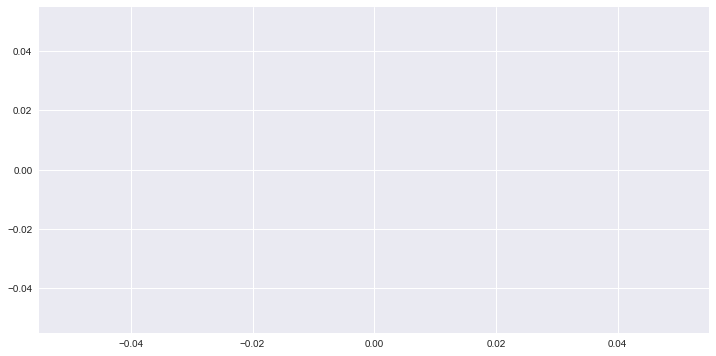

In [16]:
#Visualising the number of missing values by column
sns.set(rc={'figure.figsize':(12,6)})
plt.plot()
sns.barplot(x = df.isnull().sum().index, y = df.isnull().sum())
plt.xticks(rotation=60, ha = 'right')
plt.ylabel('number of missing values')

We can see the number of CCJs, and long term debt are the 2 columns with the most missing values, though there are 6 in total with more missing values than the rest.

In [ ]:
#Visualising the imbalance in the class labels
df['y'].value_counts()
df['y'].value_counts().plot.pie()


There is a clear class imbalance which will also need addressing

### c) Cleaning/Munging

We will then need to address issues around dimensionality (dimensionality/feature reduction, feature engineering), dealing with categorical variables in the data (currently non-numeric), class imbalance, and missing values.

The above analysis shows the potential features show correlation. Although this may suggest we could benefit from reducing the dimensionality of the data, there are a few additional considerations. Firstly, in only a few cases is the correlation relationship linear.  This means that monotonically correlated features have the potential to be independently valuable at different points in the decision space. Secondly, approaches such as Principal Component Analysis would not be helpful, as they lack interpretability/intuitive decomposition of features in relation to predictions, which is a key requirement of the use case. Forward/stepwise feature selection, or recursive feature elimination could be chosen as an alternative, but subjectively, the number of features is not so large as to require it.

The above analysis demonstrates that 'number_ccjs' and 'incorporation_date' are not suitable for features. H Yin et al 2020, explain the importance of domain knowledge. Ch_id is just a company identifier so this is not a useful predictor. Support for pension costs is also limited, and domain knowledge tells me this variable should not be considered explanatory either.

In [ ]:
#First we drop unneeded columns
df = df.drop(columns = ['number_ccjs', 'incorporation_date', 'pension_costs', 'ch_id'])

#Now we need to map sic_division categories to numbers
#Sklearn's label encoder provides an easy way to carry this out
le = LabelEncoder()
df['sic_division'] = le.fit_transform(df['sic_division'])

# nb, should we wish to restore these back to their original labels, we can use the code below:
#df['sic_division'] = le.inverse_transform(df['sic_division'])

df.head(5)

We have several choices for handling missing values (J. Ludbroock, 2008). We could remove them, but some of the columns do have a significant number of missing values – removing them would reduce the data size considerably. An alternative could be to do mean imputation, however our analysis above shows a significant distribution in the values – the mean is unlikely to be representative and would introduce greater error.

The best approach, is to use interpolation. There is no clear interpolation method that looks preferable, so I will stick with linear. 

In [ ]:
#Interpolating, using turnover for ordering to improve output(only column with no NA values)
df_filled = df.sort_values(by = ['turnover']).interpolate(method = 'linear')

A true insolvency, where 'y' is 1, is the class of interest. This constitutes the minority of samples, so there may be limitations to a model’s ability to converge to an optimal solution. There are various ways to approach this, including ignoring it, adjusting class weighting of the cost function, random oversampling (ROS), or various Synthetic Minority Oversampling Technique (SMOTE) algorithms (F Last et al 2018). ROS, SMOTE, Adaptive Synthetic oversampling (ADASYN) etc can be carried out using the imbalanced learn library.

Given the size of the dataset as whole, and the still reasonable number of minority samples (1969), the approach I have chosen is to adjust class weighting of the classifier where applicable.

The final, interpolated data can be seen below

In [ ]:
#Final df
df_filled.head(5)
#Na values are all filled
df_filled.isna().sum()

## Model design and Development:
### a) Preparation
We need to chose our classifier, and prepare the data for use with the model. This also includes splitting the data into training and evaluation samples.

#### 1. Chosing Classifier
There are numerous machine algorithms available for classification. Selection of the models that best fit this usecase, is dependent on the pros and cons of these models, and how they match the business objective.

* **Logistic Regression** models the probability of an observation being in a specific class, by taking the log-odds for a classification as a linear combination of independent variables, and converting the log-odds to a probability via a logit function. A threshold probability is used for classification, typically 0.5. This model is very fast to train, and interpretable, and works well with simpler relationships (Trevor Hastie et al 2009).

* The **k-nearest neighbours** classifier works by assigning a class to an observation based on the class of the majority of its 'k' nearest neighbouring data points in the feature space, with k being a hyper-parameter which can be optimised. 'Nearest' in this context can be defined several ways, with Euclidean distance, Manhattan distance and Hamming distance being common methods. It is more robust to more complex relationships, and although authors such as C. Huyen suggest the results are not obviously interpretable, I would critique this, and suggest that, from the perspective of explaining how the method works to stakeholders, it is still intuitive.

* A **Decision Tree** works by recursively partitioning a feature space along one feature at a time, each time splitting to maximise the information gain between the class labels. The split can be based on several approaches including Entropy and Gini information gain. It is fairly quick, and very easy to interpret, but may be prone to bias error if the tree grows too large.

* A **Random Forest** is a collection of decision trees, all created with bootstrapped data. A classification is then made by voting across the various trees. It is very accurate, and the least prone to over-fitting. However, it can be slow, and the results are hard to interpret. (C. Huyen, 2022)

* **Naïve Bayes** is a collection of algorithms that classifies based on Bayes’ theorem of conditional probability, assuming conditional independence between feature pairs. It is very fast to train and easily interpretable, and works well with text classification. It has comparatively lower accuracy in other types of data sets vs other classifiers (M Fernández-Delgado et al, 2015).

* A **Support Vector Machine** seeks to find a single hyperplane that best splits the feature space by class label, by maximising the width of the hyperplane and thus the space between classes. It can become slow to fit with numerous features, and is highly susceptible to choice of kernel (M Fernández-Delgado et al, 2015).

Based on the above evaluations, Logistic Regression, k-Nearest Neighbours and Decision Tree would be the most appropriate models for my requirements. Naïve Bayes is unlikely to be the most effective, but given its speed to train, and interpretability, I will test this too. 

Because my data set is not so large as to make multiple model testing prohibatively long/computationally demanding, it is appropriate to try all these different models, to see which one performs best. 


#### 2. Categorical Variables
P Rodrıguez et al 2018 recommends keeping ordinal values as they are, though they may need scaling to more accurately reflect the relationship between categories. In the case of nominal categories, further treatment is needed: the most common method is one hot encoding, though there are alternative methods such as Target Encoding. Though not as intuitive, it has the advantage of avoiding sparsity, and its subsequent memory constraints (P Rodrıguez et al 2018). My own reflection is, given the size of my data, the memory available on my local machine, and that there is only 1 categorical column, sparsity is unlikely to be an issue.

In [17]:
#Categorical columns, even after being mapped to numbers, cannot always be left as they are, as most classifiers
#will interpret these as having an ordinal relationship. Since the catagorical columns in this data are nominal
# we need to One Hot Encode the catagorical variables ie sic_division
#I am using a custom function I wrote, which can be applied to more columns, for future dataframes

def one_hot_encode(df,categorical_columns):
    for column in categorical_columns:
        tempdf = pd.get_dummies(df[column], prefix=column)
        df = pd.merge(
            left=df,
            right=tempdf,
            left_index=True,
            right_index=True,
            )
        df = df.drop(columns=column)
        return df

categorical_columns = ['sic_division']
df_filled = one_hot_encode(df_filled, categorical_columns)

#Split into feature and outcome variables, saving columns names for later
X = df_filled.drop(columns=['y'])
y = df_filled['y']
X_cols = X.columns

NameError: name 'df_filled' is not defined

#### 3. Model Validation Approach
There are several options for splitting the data for evaluation including the hold-out method, also known as train-test-split. This is my preference, as it is simple to use and interpret, and my dataset is sufficiently large. It also works well for training multiple models.

Although cross-validation over various k-folds can further improve the robustness of the model, Bates et al, 2022, suggest that this method may be flawed, and that using cross validated bootstrap samples of only the training data, produces a more robust model, which minimises variance error, and avoids ‘contamination’ of the test sample, improving validity of the results. This argument seems intuitively rational, and aligns well with business objectives. I will thus use k-folds cross validation for tuning hyperparemeters using only the training set


In [18]:
#Now we Split data into train and test sets - using the Hold Out method. I set the training sample to 75%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

#Scaling features because some classifiers like KNN require it, 
#and our above analysis shows the scales for different columns vary significantly
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

NameError: name 'train_test_split' is not defined

### b) Deployment
We now chose our hyperparemeters for each respective model, and train them. Hyperparameter choices in machine learning algorithms can significantly impact performance. There are multiple options available to find the optimal set of hyperparameters.

* **Grid search** – This takes a list of input values for each hyperparameter, and then tests the model on every combination of these. It can be automated in scikit learn. 

* An alternative is searching a grid, as above, but creating a table of the results for each hyperparameter combination, then plotting them. This can allow for a better visualisation of how the parameters interact, and can avoid 'overfitting' by finding the results which are the most robust to changes, rather than just the global max/min. However, such an approach gets hard to visualise in more than 3 dimensions. It is also worth noting, that the overfitting element can also be protected against by using kfolds validation - so the benefit is often not worth the effort/complexity. Also, in the real world, complexity and time resource must be considered when planning a model project's life cycle, and a grid search is very time/resource intensive __if__ there are many hyperparameters.

* **Random search** – This takes a grid, such as above, but searches it randomly until some stopping criteria is applied. Despite its seemingly random nature, it has been shown to be surprisingly effective.

* **Halvening search** – This method searches over the specified parameter values using the above methods, but with successive halving. Thus, it starts by evaluating the whole hyperparameter space with a small amount of resources, and successively selects the best candidates, using more and more resources (scikit-learn).

* There also exist newer methods involving ‘bandit’ style bootstrapping of samples (**hyperopt**), and Bayesian probability to determine where next in the hyperparameter space to search (**Bayesian Optimisation**), as well as combinations of the above, such as Bayesian Optimised Hyperband (**BOHB**).


(B. Bischl et al 2021)

Given the fact we are using classifiers with comparatively few high impact hyperparameters, we opt to use a grid search in this instance


In [19]:
#Initiate instance of various classifiers, making the weighting balanced where needed, and using max CPU cores for speed
DT = DecisionTreeClassifier(class_weight = 'balanced')
NB = GaussianNB()
KNN = KNeighborsClassifier(n_jobs = -1)
LR = LogisticRegression(class_weight = 'balanced', n_jobs = -1, max_iter = 10000)

In [20]:
#Decision Tree
dt_params = [{'max_depth': [5, 10, 15], #nb further depth will liely improve the classifier, but increases risk of overfit and
         'min_samples_leaf': [1,3,5], #loses interpretability
         'splitter': ['best','random']}]
gs_dt = GridSearchCV(DT,
                      param_grid=dt_params,
                      scoring='f1_weighted',
                      cv=5)
gs_dt.fit(X_train, y_train)
gs_dt.best_params_
gs_dt.score(X_train, y_train)

NameError: name 'X_train' is not defined

In [21]:
#Naive Bayes
nb_params = [{'var_smoothing': [0.000000001, 0.0000000001]}]
gs_nb = GridSearchCV(NB,
                      param_grid=nb_params,
                      scoring='f1_weighted',
                      cv=5)
gs_nb.fit(X_train, y_train)
gs_nb.best_params_
gs_nb.score(X_train, y_train)

NameError: name 'X_train' is not defined

In [22]:
#KNN
knn_params = [{'n_neighbors': range(3,20),#[4, 5, 6, 7, 8, 9,10, 11, 12, 13, 14, 15],
         'weights': ['uniform', 'distance'],
         'leaf_size': [15, 30, 45]}]
gs_knn = GridSearchCV(KNN,
                      param_grid=knn_params,
                      scoring='f1_weighted',
                      cv=5)
gs_knn.fit(X_train, y_train)
gs_knn.best_params_
gs_knn.score(X_train, y_train)

NameError: name 'X_train' is not defined

In [23]:
#Logistic Regression
lr_params = [{'C': [0.3, 0.5, 0.7, 1,]}]
gs_lr = GridSearchCV(LR,
                      param_grid=lr_params,
                      scoring='f1_weighted',
                      cv=5)
gs_lr.fit(X_train, y_train)
gs_lr.best_params_
gs_lr.score(X_train, y_train)

NameError: name 'X_train' is not defined

## Model Evaluation:
### a) Examples of Predictions
We produce a few examples of the models' predictions on the test data, compared against the actual label

In [24]:
# EXAMPLES from the different classifiers, Predicting examples from the test sample when compared to the real label
test_df = pd.DataFrame(X_test, columns = X_cols)
test_df['y_actual']= y_test.values
test_df['y_dt_pred'] = gs_dt.predict(test_df.iloc[:, 0:27])
test_df['y_nb_pred'] = gs_nb.predict(test_df.iloc[:, 0:27])
test_df['y_knn_pred'] = gs_knn.predict(test_df.iloc[:, 0:27])
test_df['y_lr_pred'] = gs_lr.predict(test_df.iloc[:, 0:27])
test_df

NameError: name 'X_test' is not defined

### b) Results: Model Evaluation Scores and Confusion Matrices
Given the business requirements, the most appropriate overall evaluation metric is the F1 score, which is the harmonic mean of the precision and the recall. The precision alone is also important to consider, as this is the first business goal. We loop through each classifier, and evaluate the results of the model on the out-of-sample test data

In [25]:
#Test results of each, using various metrics
model_list = [('Decision Tree', gs_dt), ('Naive Bayes', gs_nb), ('K-Nearest Neighbors', gs_knn), ('Logistic Regression', gs_lr)]

names = []
precisions = []
recalls = []
f1s = []
f1_weighteds = []
tns = []
fps = []
fns = []
tps = []

for name, model in model_list:
    y_pred = model.predict(X_test)
    
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize = 'pred').ravel() * 100
    
    names.append(name)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    f1_weighteds.append(f1_weighted)
    tns.append(tn)
    fps.append(fp)
    fns.append(fn)
    tps.append(tp)
    

summary = pd.DataFrame({'Name':names,
                       'Precision':precisions,
                       'F1': f1s,
                       'Weighted F1':f1_weighteds,
                       'True Positive %':tps,
                       'True Negative %': tns,
                       'False Positive %': fps,
                        'False Negative %': fns})
summary.sort_values(by = 'F1', ascending = False)

NameError: name 'X_test' is not defined

The results clearly show the two best models, by all the relevant evaluation metrics, are the K-Nearest Neighbour and the Decision Tree, with the KNN substantially better by all metrics. Just for clarity, I visualise the Confusion matrix for these below

In [26]:
#Confusion matrices for the test data
ConfusionMatrixDisplay.from_predictions(y_test, y_pred = gs_dt.predict(X_test))
plt.title('Decision Tree Confusion Matrix')
plt.show()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred = gs_knn.predict(X_test))
plt.title('KNN Confusion Matrix')
plt.show()

NameError: name 'ConfusionMatrixDisplay' is not defined

In [27]:
#Confusion matrices for the test data, normalised to account for imbalance
ConfusionMatrixDisplay.from_predictions(y_test, y_pred = gs_dt.predict(X_test), normalize = 'pred')
plt.title('Decision Tree Confusion Matrix- Normalised by prediction')
plt.show()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred = gs_knn.predict(X_test), normalize = 'pred')
plt.title('KNN Confusion Matrix- Normalised by prediction')
plt.show()

NameError: name 'ConfusionMatrixDisplay' is not defined

### c) Evaluation Observations:

* We have 9386 records (25% of the original data set)
* In the un-normalised version, For Decision Tree and KNN, we can see the square in the top left is bright yellow, showing a high number of negative outcomes being properly identified. Given the imbalance in the data, this is to be expected
* The other squares are dark , showing the number of false negatives, true positives, and false positves, are all quite low. Again, in unbalanced data, this is to be expected
* In the normalised version, we can see the Decision Tree has a blue colour in the lower right box now. This means the percentage of firms that become insolvent, that are corectly identified as such, is higher now, at 25%, but the number of false positives is still very high, 75% - objectively this is still not very good.
* The KNN is much better for reducing false positives, only 14% of firms which were fine, were predicted to become insolvent. 

__Based on the above, the KNN would definately be the model of choice for live deployment__

### d) A point on inspecting robustness of results for KNN
We can see how the metric (Weighted F1) changes as the hyperparameters change. This is best represented as heatmaps.

In [28]:
#Get the grid search results into a dataframe
knn_param_df = pd.DataFrame(gs_knn.cv_results_)
k_uniform = knn_param_df[knn_param_df['param_weights'] == 'uniform'] #split into 2 heatmaps
k_distance = knn_param_df[knn_param_df['param_weights'] == 'distance']
#pivot the data into a format for the heatmap, and plot
sns.heatmap(pd.pivot(k_uniform, index='param_leaf_size', columns='param_n_neighbors', values='mean_test_score'), cmap = 'PiYG')
plt.title('Weights is "Uniform"')

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [29]:
sns.heatmap(pd.pivot(k_distance, index='param_leaf_size', columns='param_n_neighbors', values='mean_test_score'), cmap = 'PiYG')
plt.title('Weights is "Distance"')

NameError: name 'k_distance' is not defined

We can see from the above, that leaf size has little to no effect on the final result. The optimal k number of 13 is quite robust, in that small adjustments in the optimal number don’t significantly alter the results. This lends support to the assertion that the model is not over-fit.

### e) Final Exercise on Model Visualisation
Whilst the KNN is intuitively easy to understand, it is harder to breakdown the exact variables which have led to a single decision. We may also wish to consider the second best performing model, in case the interpretability of this makes it more beneficial for the client, even at the expense of evaluation accuracy. Thus, just for reference, I have included a visualisation of the Decision Tree Model

A few things to note:
* A gridsearched object cannot be plotted to a tree, so we have to make a new decision tree classifier object
* Our optimised tree still had a very high depth and was not cost complexity pruned. The below example shows that despite the flow diagram, the tree is not as easy to interpret as it intially appears 
* Decision trees work on information gain, so scaling is unnecessary. Being able to use the original inputs adds interpretability

In [30]:
#Train Test split without scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
#Fit Decision tree classifier
clf = DecisionTreeClassifier(class_weight = 'balanced', max_depth= 15, min_samples_leaf= 1, splitter= 'random')
clf.fit(X_train, y_train)
#plot resulting tree (tree is very large, needs a large image size to display)
fig = plt.figure(figsize = (200,75))
_ = tree.plot_tree(clf, 
                   feature_names=X_cols,  
                   class_names= ['solv','insolv'],
                   filled=True,
                  fontsize=6)
plt.show()
#If you wish to save image
#fig.savefig(filepath, dpi=300)

NameError: name 'train_test_split' is not defined

## Conclusion
We have shown the data science lifecycle of this project, through data discovery and analysis. Different modelling choices have been trained and evaluated. The final model we should use, in my opinion, is the KNN, based on its superior evaluation metrics. This trained model can be captured for use by the client using either the pickle or joblib libraries.

## Reflection
Overall, the project has been successful. The KNN model produced good evaluation metrics, and fulfilled the brief in terms of the requirements for explainability. If the KNN was not considered explainable enough, the decision tree could be used as an alternative, though it comes with poorer evaluation outcomes. There were, however, some things that might have been improved upon in the project

For the interpolation of the missing values in the data, we used a linear method. Given the irregular shape of the variable distributions, the linear method might not be the ideal choice. One option would be to create line graphs for the various columns, arranged in ascending order, to see what pattern they take. We could then apply the appropriate method: linear, quadratic, cubic etc. If the line takes no clear pattern, then a spline may be better suited.

In regards to the timing of the interpolation, there was another consideration to factor. Ideally, the interpolation should be done after splitting the data into train/test sets. If any future data used for predictions is missing values, the imputation with a full data set would be different to imputation on just the sample. So imputation of the whole dataset in advance taints the testing sample. This is the same reason the scaler transforms the train and test samples, but is only fit on the training data.

One key stage in the data cleaning process that was not addressed, was the removal of outliers. In the case of this notebook, this was due to business requirements, but in most cases, there would usually be a desire to remove extreme and spurious data points which would reduce the goodness of fit of the classifier. We could use the scatter matrix above to try to visualise these, as well as do histograms/violin plots for each feature, so look for any unusual shapes in the distributions. We can remove these by either doing a general trim of those points furthest from the mean, or applying a winsorisation instead. 
One method to do this process computationally, is to use sklearn.covariance.EllipticEnvelope (Rousseeuw, P.J., Van Driessen, K). This models fits the initial data, and then creates a binary label for each data point, describing it as an outlier or not. We can then filter to exclude the outliers. 

Another area we could have looked at was alternative measurements of classifier fit, such as AUCROC. This measures the goodness of fit across different probability predictions (sklearn’s default is to use a 50% probability threshold). This is an interesting metric, as it can sometimes reveal overfitting due to probability threshold selection. Indeed, the probability threshold could also have been tested as a hyperparameter, using the predict_proba() method.

The sample splitting for the project was done using train test split, with hyperparameter evaluation done using kfolds cross validation. There were good reasons for this, as stated above, but I may have dismissed a stratified k-folds cross validation approach too readily. Keeping a hold out test set was recommended by Bates et al, 2022, and the scikit-learn documentation, but given the imbalanced nature of the data, a stratified fold may have improved the fit of the classifier.  My objection on this mainly came in the form of wanting to avoid overfitting, since a stratified sample is not representative of the natural variance found in new data.

One other point to reflect on, was the treatment of the Naïve Bayes model. This model doesn’t fundamentaly handle a mix of categorical and discrete data features.  I have used the Gaussian model given the nature of most of the features, but in reality, this will have poor results for the binary features. The ideal approach here would have been to use two models: one to find the probability from the categorical variables (using predict_proba from sklearn's BernoulliNB model, fit to the sector variable), and another to calculate the probabilities from the other continuous variables (using predict_proba from sklearn's GaussianNB). We then have to multiply the probabilities from both models and divide by the prior from either model, and then divide again by the sum (over the classes) to normalize. In reality, given the poor probability of the NB model, it is unlikely to have impacted the final model choice.

Lastly, further to the model options discussed above, there are also relatively newer options available, including gradient boosting methods (eg XGBoost, lightGBM) that sequentially build from weak learners, and also neural networks. These could inform updates on the project in the future, though they still lack interpretability. Much as I mention above, how the KNN may be rejected due to lack of interpretability, it may go the other way. In some cases, stakeholders may opt to change their requirements in the future, dialling down the desire for interpretability in exchange for significantly better performance.


### References
1. https://www.investopedia.com/terms/i/interestcoverageratio.asp accessed 2023
2. The Importance of Domain Knowledge, Haixing Yin, Fan Fan, Jiazhi Zhang, Hanyang Li and Ting Fung Lau, MLD, CMU, August 31, 2020
3. Exploratory Data Analysis, John W. Tukey, 1977
4. Ludbrook J. Outlying observations and missing values: how should they be handled? Clin Exp Pharmacol Physiol. 2008;35(5–6):670–8.
5. Felix Last, Georgios Douzas, Fernando Bacao, Oversampling for Imbalanced Learning Based on K-Means and SMOTE, Information Sciences 465 (2018) 1-20
6. Hyperparameter Optimization: Foundations, Algorithms, Best Practices and Open Challenges Bernd Bischl, Martin Binder , Michel Lang, Tobias Pielok , Jakob Richter , Stefan Coors , Janek Thomas , Theresa Ullmann , Marc Becker , Anne-Laure Boulesteix , Difan Deng , and Marius Lindauer, Department of Statistics, Ludwig-Maximilians-Universit¨at M¨unchen – 24 Nov 2021
7. https://scikit-learn.org/ accessed 2023
8. Trevor Hastie, Robert Tibshirani, and Jerome Friedman, The Elements of Statistical Learning: Data Mining, Inference, and Prediction, 2009
9. Chip Huyen, Designing Machine Learning Systems: An Iterative Process for Production-Ready Applications – 31 May 2022
10. Manuel Fernández-Delgado, Eva Cernadas, Senén Barro, Dinani Amorim, Do we need hundreds of classifiers to solve real world classification problems?. The Journal of Machine Learning Research, Volume 15, Issue 1January 2014 pp 3133–3181
11. Beyond One-hot Encoding: lower dimensional target embedding Pau Rodrıguez, Miguel A. Bautista, Jordi Gonzalez, Sergio Escalera, Computer Vision Center, Universitat Autonoma de Barcelona, Spain, Heidelberg Collaboratory for Image Processing, Heidelberg University, Germany, University of Barcelona, Barcelona, Spain, May 17, 2018
12. Stephen Bates, Trevor Hastie, Robert Tibshirani, Cross-validation: what does it estimate and how well does it do it? 2022
13. Rousseeuw, P.J., Van Driessen, K. “A fast algorithm for the minimum covariance determinant estimator” Technometrics 41(3), 212 (1999)
14. https://scikit-learn.org/stable/modules/cross_validation.html accessed 2023

